# DuckDB Deep Analytics: Impact Learners Dataset

**30 Complex Analytical Queries on 1.7M Learners**

---

## Overview

This notebook provides comprehensive analytics on the Impact Learners dataset using DuckDB - a fast, in-memory analytical database perfect for exploring large CSV files.

### Dataset Stats
- **Size**: 1.7M rows, 2.5GB
- **Unique Learners**: 1,597,167 (by hashed_email)
- **Programs**: 26 unique programs
- **Countries**: 50+ countries

### Query Categories
1. **Geographic Analysis** (Q1-Q6): Country/city distributions, Egypt vs Morocco
2. **Program Analysis** (Q7-Q12): Enrollments, completion rates, cohorts
3. **Learning State Analysis** (Q13-Q17): Active/Graduate/Dropout patterns
4. **Employment Outcomes** (Q18-Q23): Job placement, salaries, ventures
5. **Cross-Dimensional** (Q24-Q30): Complex multi-factor analysis

### Program Matching Modes

This notebook supports two matching modes for program queries:

| Mode | Pattern | Example | Use Case |
|------|---------|---------|----------|
| **SPECIFIC** | `LIKE '%data analytics%'` | Matches "Data Analytics" only | Matches Kweli (Neo4j) results |
| **BROAD** | `LIKE '%data%'` | Matches Data Analytics, Data Scientist, Data Engineering | Wider analysis |

When comparing results with Kweli (Neo4j), use **SPECIFIC** matching to get equivalent results.

---

## Setup: Load Data and Configure DuckDB

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Configure DuckDB for optimal performance
conn = duckdb.connect(":memory:")

# Set memory limit and threads
conn.execute("SET memory_limit='8GB'")
conn.execute("SET threads=4")

print("DuckDB configured: 8GB memory, 4 threads")

DuckDB configured: 8GB memory, 4 threads


In [3]:
# Load CSV data
csv_path = "../data/raw/impact_learners_profile-1759316791571.csv"

print(f"Loading CSV from: {csv_path}")
print("This may take 30-60 seconds for 1.7M rows...")

conn.execute(f"""
    CREATE TABLE learners AS 
    SELECT * FROM read_csv_auto('{csv_path}', 
                                header=true, 
                                sample_size=100000,
                                ignore_errors=true)
""")

# Verify load
result = conn.execute("SELECT COUNT(*) as cnt FROM learners").fetchone()
print(f"\nLoaded {result[0]:,} rows successfully")

Loading CSV from: ../data/raw/impact_learners_profile-1759316791571.csv
This may take 30-60 seconds for 1.7M rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Loaded 1,597,198 rows successfully


In [4]:
# Create helper macros for sentinel value handling
# -99 = missing numeric, 1970-01-01 = invalid date

conn.execute("""
    CREATE OR REPLACE MACRO safe_double(val) AS
        CASE WHEN val IN ('-99', '', 'n/a', NULL) THEN NULL 
             ELSE TRY_CAST(val AS DOUBLE) END
""")

conn.execute("""
    CREATE OR REPLACE MACRO safe_date(val) AS
        CASE WHEN val IN ('1970-01-01', '', 'n/a', NULL) THEN NULL 
             ELSE TRY_CAST(val AS DATE) END
""")

conn.execute("""
    CREATE OR REPLACE MACRO safe_int(val) AS
        CASE WHEN val IN ('-99', '', 'n/a', NULL) THEN NULL 
             ELSE TRY_CAST(val AS INTEGER) END
""")

# Create macro for flexible program matching (matches Kweli's behavior)
# Use ILIKE for case-insensitive matching with CONTAINS semantics
conn.execute("""
    CREATE OR REPLACE MACRO matches_program(program_json, search_term) AS
        LOWER(json_extract_string(program_json, '$[0].program_name')) ILIKE '%' || LOWER(search_term) || '%'
""")

print("Helper macros created: safe_double(), safe_date(), safe_int(), matches_program()")
print("\nUsage: matches_program(learning_details, 'data analytics') - case-insensitive CONTAINS matching")

Helper macros created: safe_double(), safe_date(), safe_int(), matches_program()

Usage: matches_program(learning_details, 'data analytics') - case-insensitive CONTAINS matching


In [5]:
# Quick data overview
schema_df = conn.execute("DESCRIBE learners").df()
print(f"Total columns: {len(schema_df)}")
print("\nKey columns:")
key_cols = ['hashed_email', 'gender', 'country_of_residence', 'city_of_residence',
            'is_graduate_learner', 'is_active_learner', 'is_a_dropped_out',
            'is_wage_employed', 'is_running_a_venture', 'learning_details']
print(schema_df[schema_df['column_name'].isin(key_cols)].to_string(index=False))

Total columns: 58

Key columns:
         column_name column_type null  key default extra
        hashed_email     VARCHAR  YES None    None  None
              gender     VARCHAR  YES None    None  None
country_of_residence     VARCHAR  YES None    None  None
   city_of_residence     VARCHAR  YES None    None  None
 is_graduate_learner      BIGINT  YES None    None  None
   is_active_learner      BIGINT  YES None    None  None
    is_a_dropped_out      BIGINT  YES None    None  None
    learning_details     VARCHAR  YES None    None  None
is_running_a_venture      BIGINT  YES None    None  None
    is_wage_employed      BIGINT  YES None    None  None


---

## Category 1: Geographic Analysis (Q1-Q6)

Analyzing learner distribution across countries and cities, with focus on Egypt and Morocco.

Q1: Top 20 Countries by Learner Count
                                             country  total_learners  percentage
                                             Nigeria          552542       35.10
                                               Kenya          185443       11.78
                                               Egypt          174773       11.10
                                               Ghana          142880        9.08
                                             Morocco          134015        8.51
                                        South Africa          116331        7.39
                                            Ethiopia          106205        6.75
                                              Rwanda           47883        3.04
                                              Uganda           19862        1.26
                                            Zimbabwe            9522        0.60
                                              Malawi            8885   

/var/folders/gz/yvddvndd12z219c7nkshxj580000gn/T/ipykernel_87759/1425282436.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=q1.head(15), x='country', y='total_learners', palette='viridis', ax=ax)


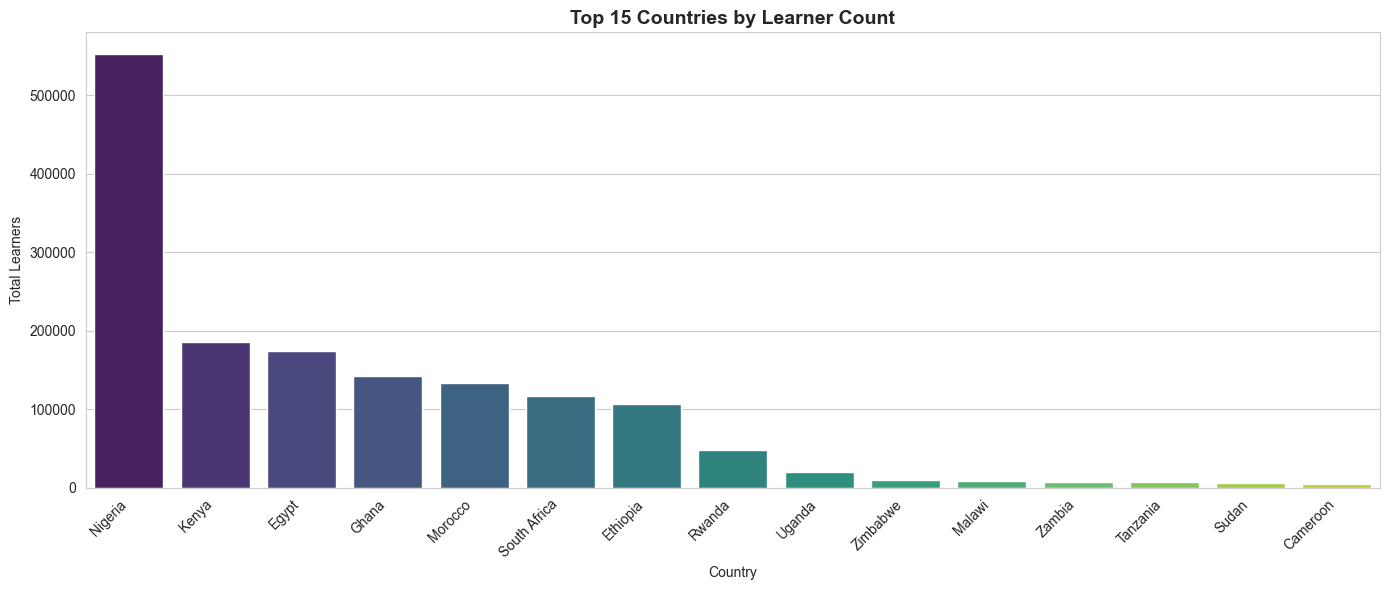

In [6]:
# Q1: Total learners by country of residence
# Purpose: Geographic distribution overview

q1 = conn.execute("""
SELECT 
    country_of_residence AS country,
    COUNT(*) AS total_learners,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM learners
WHERE country_of_residence IS NOT NULL 
  AND country_of_residence NOT IN ('n/a', '')
GROUP BY country_of_residence
ORDER BY total_learners DESC
LIMIT 20
""").df()

print("Q1: Top 20 Countries by Learner Count")
print("=" * 50)
print(q1.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=q1.head(15), x='country', y='total_learners', palette='viridis', ax=ax)
ax.set_title('Top 15 Countries by Learner Count', fontsize=14, fontweight='bold')
ax.set_xlabel('Country')
ax.set_ylabel('Total Learners')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# Q2: Data Analytics students in Egypt - EXACT vs BROAD matching
# Purpose: Country-specific program analysis with flexible matching

# First, show what programs match different search terms
print("Programs matching 'data' (BROAD):")
q2_programs_broad = conn.execute("""
SELECT DISTINCT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS learners
FROM learners
WHERE LOWER(country_of_residence) LIKE '%egypt%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data%'
GROUP BY 1
ORDER BY learners DESC
""").df()
print(q2_programs_broad.to_string(index=False))

print("\n" + "=" * 60)
print("Programs matching 'data analytics' (SPECIFIC - matches Kweli):")
q2_programs_specific = conn.execute("""
SELECT DISTINCT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS learners
FROM learners
WHERE LOWER(country_of_residence) LIKE '%egypt%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data analytics%'
GROUP BY 1
ORDER BY learners DESC
""").df()
print(q2_programs_specific.to_string(index=False))

print("\n" + "=" * 60)
# SPECIFIC: Data Analytics only (matches Kweli)
q2_specific = conn.execute("""
SELECT 
    'Data Analytics (SPECIFIC)' AS match_type,
    COUNT(*) AS total_learners,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'enrolled' THEN 1 ELSE 0 END) AS active,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE LOWER(l.country_of_residence) LIKE '%egypt%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data analytics%'
""").df()

# BROAD: Any program with 'data' in the name
q2_broad = conn.execute("""
SELECT 
    'All Data Programs (BROAD)' AS match_type,
    COUNT(*) AS total_learners,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'enrolled' THEN 1 ELSE 0 END) AS active,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE LOWER(l.country_of_residence) LIKE '%egypt%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data%'
""").df()

import pandas as pd
q2_comparison = pd.concat([q2_specific, q2_broad], ignore_index=True)

print("\nQ2: Data Students in Egypt - SPECIFIC vs BROAD Matching")
print("=" * 80)
print(q2_comparison.to_string(index=False))
print("\n📊 SPECIFIC (149) matches Kweli's result")
print("📊 BROAD (359) includes Data Analytics + Data Scientist + Data Engineering")

Programs matching 'data' (BROAD):
    program_name  learners
  Data Scientist       199
  Data Analytics       149
Data Engineering        11

Programs matching 'data analytics' (SPECIFIC - matches Kweli):
  program_name  learners
Data Analytics       149


Q2: Data Students in Egypt - SPECIFIC vs BROAD Matching
               match_type  total_learners  graduates  active  dropped_out  graduation_rate_pct
Data Analytics (SPECIFIC)             149       15.0     0.0        134.0                10.07
All Data Programs (BROAD)             359       56.0     0.0        303.0                15.60

📊 SPECIFIC (149) matches Kweli's result
📊 BROAD (359) includes Data Analytics + Data Scientist + Data Engineering


In [8]:
# Q2b: Detailed breakdown of Data Analytics in Egypt by city
# Using SPECIFIC matching (Data Analytics only - matches Kweli)
q2b = conn.execute("""
SELECT 
    l.city_of_residence AS city,
    COUNT(*) AS learner_count,
    SUM(is_graduate_learner) AS graduates,
    ROUND(SUM(is_graduate_learner) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE LOWER(l.country_of_residence) LIKE '%egypt%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data analytics%'
  AND l.city_of_residence IS NOT NULL
  AND l.city_of_residence NOT IN ('n/a', '')
GROUP BY l.city_of_residence
HAVING COUNT(*) >= 3
ORDER BY learner_count DESC
LIMIT 15
""").df()

print("Q2b: Data Analytics in Egypt by City (SPECIFIC matching)")
print("=" * 60)
print(q2b.to_string(index=False))

# Also show BROAD for comparison
q2b_broad = conn.execute("""
SELECT 
    l.city_of_residence AS city,
    COUNT(*) AS learner_count,
    SUM(is_graduate_learner) AS graduates,
    ROUND(SUM(is_graduate_learner) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE LOWER(l.country_of_residence) LIKE '%egypt%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data%'
  AND l.city_of_residence IS NOT NULL
  AND l.city_of_residence NOT IN ('n/a', '')
GROUP BY l.city_of_residence
HAVING COUNT(*) >= 3
ORDER BY learner_count DESC
LIMIT 15
""").df()

print("\nQ2b (BROAD): All Data Programs in Egypt by City")
print("=" * 60)
print(q2b_broad.to_string(index=False))

Q2b: Data Analytics in Egypt by City (SPECIFIC matching)
      city  learner_count  graduates  graduation_rate_pct
     cairo             63        7.0                11.11
     Cairo             47        5.0                10.64
      giza             20        0.0                 0.00
alexandria             12        2.0                16.67

Q2b (BROAD): All Data Programs in Egypt by City
           city  learner_count  graduates  graduation_rate_pct
          cairo            158       23.0                14.56
          Cairo            124       28.0                22.58
           giza             39        1.0                 2.56
     alexandria             18        2.0                11.11
      port said              5        0.0                 0.00
          luxor              4        0.0                 0.00
       ismailia              3        0.0                 0.00
kafr ash shaykh              3        1.0                33.33


In [9]:
# Q3: Data Analytics students in Morocco - EXACT vs BROAD matching
# Purpose: Country-specific program analysis with flexible matching

# First, show what programs match different search terms
print("Programs matching 'data' (BROAD):")
q3_programs_broad = conn.execute("""
SELECT DISTINCT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS learners
FROM learners
WHERE LOWER(country_of_residence) LIKE '%morocco%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data%'
GROUP BY 1
ORDER BY learners DESC
""").df()
print(q3_programs_broad.to_string(index=False))

print("\n" + "=" * 60)
print("Programs matching 'data analytics' (SPECIFIC - matches Kweli):")
q3_programs_specific = conn.execute("""
SELECT DISTINCT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS learners
FROM learners
WHERE LOWER(country_of_residence) LIKE '%morocco%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data analytics%'
GROUP BY 1
ORDER BY learners DESC
""").df()
print(q3_programs_specific.to_string(index=False))

print("\n" + "=" * 60)
# SPECIFIC: Data Analytics only (matches Kweli)
q3_specific = conn.execute("""
SELECT 
    'Data Analytics (SPECIFIC)' AS match_type,
    COUNT(*) AS total_learners,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'enrolled' THEN 1 ELSE 0 END) AS active,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE LOWER(l.country_of_residence) LIKE '%morocco%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data analytics%'
""").df()

# BROAD: Any program with 'data' in the name
q3_broad = conn.execute("""
SELECT 
    'All Data Programs (BROAD)' AS match_type,
    COUNT(*) AS total_learners,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'enrolled' THEN 1 ELSE 0 END) AS active,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE LOWER(l.country_of_residence) LIKE '%morocco%'
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data%'
""").df()

import pandas as pd
q3_comparison = pd.concat([q3_specific, q3_broad], ignore_index=True)

print("\nQ3: Data Students in Morocco - SPECIFIC vs BROAD Matching")
print("=" * 80)
print(q3_comparison.to_string(index=False))
print("\n📊 SPECIFIC matches Kweli's result (Data Analytics only)")
print("📊 BROAD includes Data Analytics + Data Scientist + Data Engineering")

Programs matching 'data' (BROAD):
    program_name  learners
  Data Analytics       299
  Data Scientist       188
Data Engineering        17

Programs matching 'data analytics' (SPECIFIC - matches Kweli):
  program_name  learners
Data Analytics       299


Q3: Data Students in Morocco - SPECIFIC vs BROAD Matching
               match_type  total_learners  graduates  active  dropped_out  graduation_rate_pct
Data Analytics (SPECIFIC)             299        6.0     0.0        293.0                 2.01
All Data Programs (BROAD)             504       36.0     0.0        468.0                 7.14

📊 SPECIFIC matches Kweli's result (Data Analytics only)
📊 BROAD includes Data Analytics + Data Scientist + Data Engineering


In [10]:
# Q3b: Egypt vs Morocco comparison - SPECIFIC vs BROAD matching
# Using enrollment_status from learning_details JSON (enrolled = active)

# SPECIFIC matching (Data Analytics only - matches Kweli)
q3b_specific = conn.execute("""
SELECT 
    CASE 
        WHEN LOWER(l.country_of_residence) LIKE '%egypt%' THEN 'Egypt'
        WHEN LOWER(l.country_of_residence) LIKE '%morocco%' THEN 'Morocco'
    END AS country,
    'Data Analytics (SPECIFIC)' AS match_type,
    COUNT(*) AS total_learners,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE (LOWER(l.country_of_residence) LIKE '%egypt%' OR LOWER(l.country_of_residence) LIKE '%morocco%')
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data analytics%'
GROUP BY 1, 2
ORDER BY total_learners DESC
""").df()

# BROAD matching (any data-related program)
q3b_broad = conn.execute("""
SELECT 
    CASE 
        WHEN LOWER(l.country_of_residence) LIKE '%egypt%' THEN 'Egypt'
        WHEN LOWER(l.country_of_residence) LIKE '%morocco%' THEN 'Morocco'
    END AS country,
    'All Data Programs (BROAD)' AS match_type,
    COUNT(*) AS total_learners,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners l
WHERE (LOWER(l.country_of_residence) LIKE '%egypt%' OR LOWER(l.country_of_residence) LIKE '%morocco%')
  AND LOWER(json_extract_string(learning_details, '$[0].program_name')) LIKE '%data%'
GROUP BY 1, 2
ORDER BY total_learners DESC
""").df()

import pandas as pd
q3b_combined = pd.concat([q3b_specific, q3b_broad], ignore_index=True).sort_values(['country', 'match_type'])

print("\nQ3b: Egypt vs Morocco - Data Programs Comparison")
print("=" * 90)
print(q3b_combined.to_string(index=False))
print("\n📊 SPECIFIC = Only 'Data Analytics' program (matches Kweli)")
print("📊 BROAD = All programs with 'data' in name (Data Analytics + Data Scientist + Data Engineering)")


Q3b: Egypt vs Morocco - Data Programs Comparison
country                match_type  total_learners  graduates  dropped_out  graduation_rate_pct
  Egypt All Data Programs (BROAD)             359       56.0        303.0                15.60
  Egypt Data Analytics (SPECIFIC)             149       15.0        134.0                10.07
Morocco All Data Programs (BROAD)             504       36.0        468.0                 7.14
Morocco Data Analytics (SPECIFIC)             299        6.0        293.0                 2.01

📊 SPECIFIC = Only 'Data Analytics' program (matches Kweli)
📊 BROAD = All programs with 'data' in name (Data Analytics + Data Scientist + Data Engineering)


In [11]:
# Q4: Active learners by country (currently enrolled)
# Purpose: Current engagement by geography

q4 = conn.execute("""
SELECT 
    country_of_residence AS country,
    COUNT(*) AS active_learners,
    SUM(CASE WHEN gender = 'female' THEN 1 ELSE 0 END) AS female_count,
    ROUND(SUM(CASE WHEN gender = 'female' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS female_pct
FROM learners
WHERE is_active_learner = 1
  AND country_of_residence IS NOT NULL
  AND country_of_residence NOT IN ('n/a', '')
GROUP BY country_of_residence
ORDER BY active_learners DESC
LIMIT 20
""").df()

print("Q4: Active Learners by Country")
print("=" * 50)
print(q4.to_string(index=False))

Q4: Active Learners by Country
                 country  active_learners  female_count  female_pct
                 Nigeria            23950       13645.0       56.97
                   Kenya            18358        8991.0       48.98
                   Ghana            13444        4476.0       33.29
                 Morocco            10036        3416.0       34.04
                   Egypt             7331        2605.0       35.53
            South Africa             6907        4009.0       58.04
                Ethiopia             6798        2150.0       31.63
                  Rwanda             5841        1816.0       31.09
                  Uganda              602         335.0       55.65
                Zimbabwe              348         234.0       67.24
United States of America              209         111.0       53.11
                Cameroon              189         102.0       53.97
                Tanzania              156          75.0       48.08
                 

Q5: Graduation Rates by Country (1000+ enrollments)
                                             country  total_enrollments  graduates  dropouts  active  graduation_rate_pct  dropout_rate_pct
                                            Portugal               1008      537.0     458.0    13.0                53.27             45.44
United Kingdom of Great Britain and Northern Ireland               2627      773.0    1849.0     5.0                29.43             70.38
                                               Ghana             142880    31039.0   98397.0 13444.0                21.72             68.87
                                               Kenya             185443    38022.0  129063.0 18358.0                20.50             69.60
                                             Nigeria             552542   108467.0  420125.0 23950.0                19.63             76.03
                                United Arab Emirates               2353      429.0    1803.0   121.0        

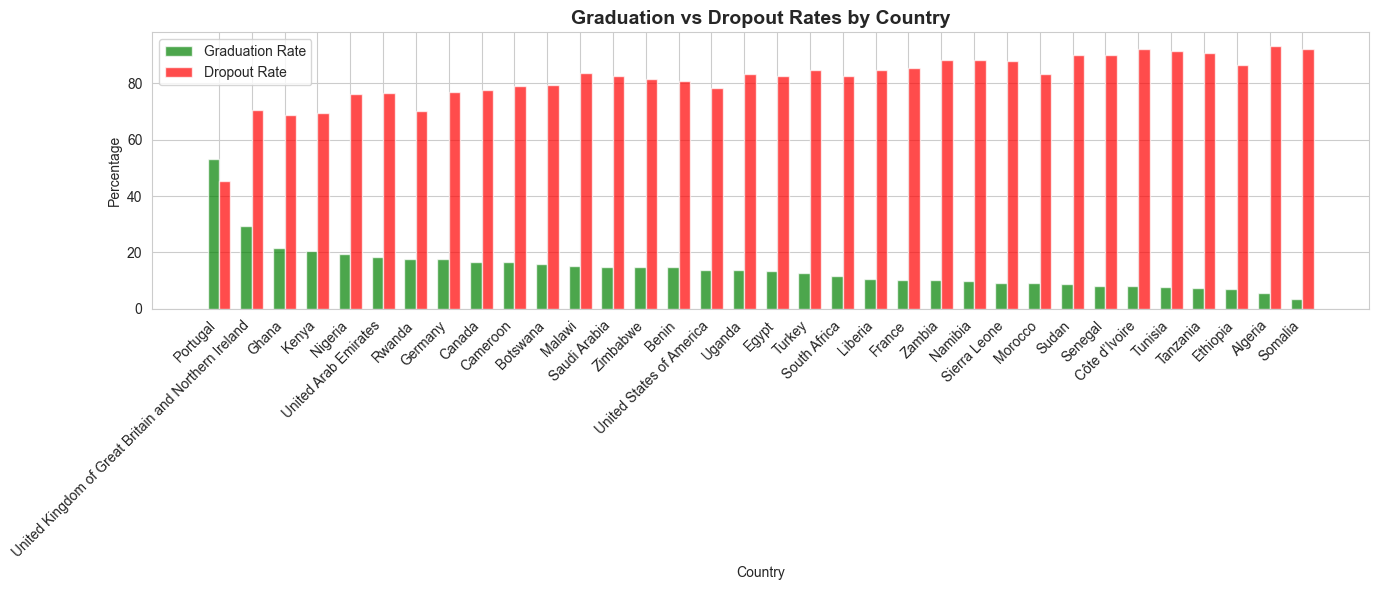

In [12]:
# Q5: Graduation rates by country (countries with 1000+ enrollments)
# Purpose: Compare program success across geographies

q5 = conn.execute("""
WITH country_stats AS (
    SELECT 
        country_of_residence AS country,
        COUNT(*) AS total_enrollments,
        SUM(is_graduate_learner) AS graduates,
        SUM(is_a_dropped_out) AS dropouts,
        SUM(is_active_learner) AS active
    FROM learners
    WHERE country_of_residence IS NOT NULL
      AND country_of_residence NOT IN ('n/a', '')
    GROUP BY country_of_residence
    HAVING COUNT(*) >= 1000
)
SELECT 
    country,
    total_enrollments,
    graduates,
    dropouts,
    active,
    ROUND(graduates * 100.0 / total_enrollments, 2) AS graduation_rate_pct,
    ROUND(dropouts * 100.0 / total_enrollments, 2) AS dropout_rate_pct
FROM country_stats
ORDER BY graduation_rate_pct DESC
""").df()

print("Q5: Graduation Rates by Country (1000+ enrollments)")
print("=" * 60)
print(q5.to_string(index=False))

# Visualization
if len(q5) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(q5))
    width = 0.35
    ax.bar([i - width/2 for i in x], q5['graduation_rate_pct'], width, label='Graduation Rate', color='green', alpha=0.7)
    ax.bar([i + width/2 for i in x], q5['dropout_rate_pct'], width, label='Dropout Rate', color='red', alpha=0.7)
    ax.set_xlabel('Country')
    ax.set_ylabel('Percentage')
    ax.set_title('Graduation vs Dropout Rates by Country', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(q5['country'], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [13]:
# Q6: Top cities by learner count with graduation rates
# Purpose: City-level granularity for targeting

q6 = conn.execute("""
SELECT 
    country_of_residence AS country,
    city_of_residence AS city,
    COUNT(*) AS total_learners,
    SUM(is_graduate_learner) AS graduates,
    ROUND(SUM(is_graduate_learner) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners
WHERE city_of_residence IS NOT NULL
  AND city_of_residence NOT IN ('n/a', '')
GROUP BY country_of_residence, city_of_residence
HAVING COUNT(*) >= 500
ORDER BY total_learners DESC
LIMIT 30
""").df()

print("Q6: Top 30 Cities by Learner Count (500+ learners)")
print("=" * 70)
print(q6.to_string(index=False))

Q6: Top 30 Cities by Learner Count (500+ learners)
     country          city  total_learners  graduates  graduation_rate_pct
     Nigeria         lagos          165772    43080.0                25.99
       Kenya       nairobi          125186    28308.0                22.61
     Nigeria         Abuja          119189     8622.0                 7.23
       Ghana         accra           87555    21004.0                23.99
       Egypt         Cairo           73980     7286.0                 9.85
    Ethiopia   addis ababa           72642     6410.0                 8.82
       Egypt         cairo           58981     9428.0                15.98
     Morocco         Rabat           55692     4669.0                 8.38
     Nigeria         abuja           45304    11355.0                25.06
      Rwanda        kigali           42733     7735.0                18.10
South Africa     Cape Town           32921     1813.0                 5.51
     Morocco    casablanca           30964     33

---

## Category 2: Program Analysis (Q7-Q12)

Analyzing program enrollments, completion rates, and performance metrics.

Q7: Total Enrollments per Program
                        program_name  total_enrollments  pct_of_total
                Software Engineering             467697         29.28
     ALX AiCE - AI Career Essentials             449135         28.12
                   Virtual Assistant             323220         20.24
                     ALX Foundations             194584         12.18
                   Financial Analyst              46133          2.89
                        ALX Pathways              38113          2.39
                AI Career Essentials              21118          1.32
                     Founder Academy              19413          1.22
                             Udacity              15429          0.97
                  ALX AI Starter Kit               6166          0.39
         Freelancer Academy - 2-week               4383          0.27
            Founder Academy - 4-week               3203          0.20
                      Data Analytics               2754 

/var/folders/gz/yvddvndd12z219c7nkshxj580000gn/T/ipykernel_87759/3028649031.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=q7.head(15), y='program_name', x='total_enrollments', palette='viridis', ax=ax)


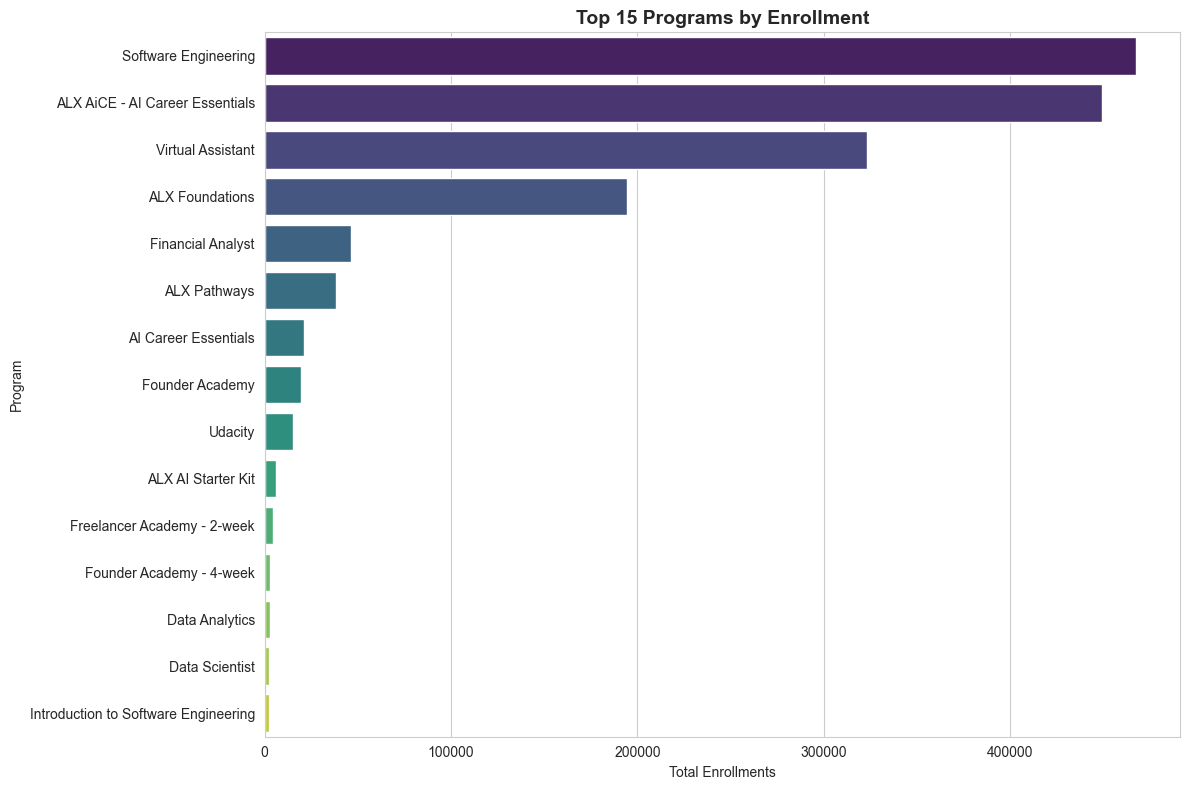

In [14]:
# Q7: Total enrollments per program (from learning_details JSON)
# Purpose: Program popularity ranking
# Note: Uses $[0].program_name since most learners have single program entry

q7 = conn.execute("""
SELECT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS total_enrollments,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM learners), 2) AS pct_of_total
FROM learners
WHERE json_extract_string(learning_details, '$[0].program_name') IS NOT NULL
GROUP BY json_extract_string(learning_details, '$[0].program_name')
ORDER BY total_enrollments DESC
""").df()

print("Q7: Total Enrollments per Program")
print("=" * 60)
print(q7.to_string(index=False))

# Visualization
if len(q7) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(data=q7.head(15), y='program_name', x='total_enrollments', palette='viridis', ax=ax)
    ax.set_title('Top 15 Programs by Enrollment', fontsize=14, fontweight='bold')
    ax.set_xlabel('Total Enrollments')
    ax.set_ylabel('Program')
    plt.tight_layout()
    plt.show()

In [15]:
# Q8: Graduation rates by program
# Purpose: Program effectiveness comparison

q8 = conn.execute("""
SELECT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS total_enrolled,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropouts,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners
GROUP BY json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 100
ORDER BY graduation_rate_pct DESC
""").df()

print("Q8: Graduation Rates by Program")
print("=" * 70)
print(q8.to_string(index=False))

Q8: Graduation Rates by Program
                        program_name  total_enrolled  graduates  dropouts  graduation_rate_pct
         Young Entrepreneurs Program             201      201.0       0.0               100.00
              AWS Cloud Practitioner             155       69.0      86.0                44.52
                  ALX AI Starter Kit            6166     2580.0    3586.0                41.84
                   Virtual Assistant          323220   115413.0  179218.0                35.71
                   Financial Analyst           46133    13768.0   32365.0                29.84
                             Udacity           15429     4058.0   11371.0                26.30
                     Founder Academy           19413     4986.0   14427.0                25.68
            Back-End Web Development             224       47.0     177.0                20.98
                     ALX Foundations          194584    33829.0  121927.0                17.39
     ALX AiCE - AI

In [16]:
# Q9: Cohort performance analysis
# Purpose: Track cohort-level trends

q9 = conn.execute("""
SELECT 
    json_extract_string(learning_details, '$[0].cohort_code') AS cohort_code,
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS enrollments,
    ROUND(AVG(CASE 
        WHEN json_extract_string(learning_details, '$[0].lms_overall_score') NOT IN ('-99', '', 'n/a') 
        THEN TRY_CAST(json_extract_string(learning_details, '$[0].lms_overall_score') AS DOUBLE) 
        ELSE NULL 
    END), 2) AS avg_lms_score,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners
GROUP BY 
    json_extract_string(learning_details, '$[0].cohort_code'),
    json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 100
ORDER BY enrollments DESC
LIMIT 30
""").df()

print("Q9: Cohort Performance Analysis (Top 30 cohorts)")
print("=" * 80)
print(q9.to_string(index=False))

Q9: Cohort Performance Analysis (Top 30 cohorts)
    cohort_code                    program_name  enrollments  avg_lms_score  graduation_rate_pct
        AiCE-C3 ALX AiCE - AI Career Essentials       143842          19.13                15.77
        AiCE-C4 ALX AiCE - AI Career Essentials       102290          12.24                10.91
        AiCE-C2 ALX AiCE - AI Career Essentials        91106           0.00                10.35
          VA-C6               Virtual Assistant        83803          44.86                40.25
         SE-C13            Software Engineering        73902            NaN                 0.65
         SE-C12            Software Engineering        71920            NaN                 0.35
          VA-C5               Virtual Assistant        50817          48.45                43.55
          SE-C9            Software Engineering        46680            NaN                 1.49
          VA-C4               Virtual Assistant        40186          53.09   

In [17]:
# Q10: Program duration analysis
# Purpose: Understand program length patterns

q10 = conn.execute("""
SELECT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS enrollments,
    ROUND(AVG(
        CASE 
            WHEN json_extract_string(learning_details, '$[0].program_start_date') NOT IN ('1970-01-01', '', 'n/a')
             AND json_extract_string(learning_details, '$[0].program_end_date') NOT IN ('1970-01-01', '', 'n/a')
            THEN DATEDIFF('day', 
                TRY_CAST(json_extract_string(learning_details, '$[0].program_start_date') AS DATE),
                TRY_CAST(json_extract_string(learning_details, '$[0].program_end_date') AS DATE))
            ELSE NULL
        END
    ), 1) AS avg_duration_days,
    ROUND(AVG(
        CASE 
            WHEN json_extract_string(learning_details, '$[0].program_start_date') NOT IN ('1970-01-01', '', 'n/a')
             AND json_extract_string(learning_details, '$[0].program_end_date') NOT IN ('1970-01-01', '', 'n/a')
            THEN DATEDIFF('day', 
                TRY_CAST(json_extract_string(learning_details, '$[0].program_start_date') AS DATE),
                TRY_CAST(json_extract_string(learning_details, '$[0].program_end_date') AS DATE)) / 30.0
            ELSE NULL
        END
    ), 1) AS avg_duration_months
FROM learners
GROUP BY json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 100
ORDER BY avg_duration_days DESC NULLS LAST
""").df()

print("Q10: Program Duration Analysis")
print("=" * 70)
print(q10.to_string(index=False))

Q10: Program Duration Analysis
                        program_name  enrollments  avg_duration_days  avg_duration_months
                      Data Scientist         2475              342.8                 11.4
                Software Engineering       467697              311.8                 10.4
                     Founder Academy        19413              232.6                  7.8
            Back-End Web Development          224              186.8                  6.2
           Front-End Web Development          185              168.1                  5.6
                             Udacity        15429              135.0                  4.5
                        ALX Pathways        38113              121.2                  4.0
Introduction to Software Engineering         2303              120.0                  4.0
              AWS Cloud Practitioner          155              105.2                  3.5
                      Data Analytics         2754               92.2 

In [18]:
# Q11: Assignment and test completion rates by program
# Purpose: Learning engagement analysis

q11 = conn.execute("""
SELECT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS enrollments,
    ROUND(AVG(CASE 
        WHEN json_extract_string(learning_details, '$[0].assignment_completion_rate') NOT IN ('-99', '', 'n/a')
        THEN TRY_CAST(json_extract_string(learning_details, '$[0].assignment_completion_rate') AS DOUBLE)
        ELSE NULL 
    END), 2) AS avg_assignment_completion_pct,
    ROUND(AVG(CASE 
        WHEN json_extract_string(learning_details, '$[0].test_completion_rate') NOT IN ('-99', '', 'n/a')
        THEN TRY_CAST(json_extract_string(learning_details, '$[0].test_completion_rate') AS DOUBLE)
        ELSE NULL 
    END), 2) AS avg_test_completion_pct,
    ROUND(AVG(CASE 
        WHEN json_extract_string(learning_details, '$[0].milestone_completion_rate') NOT IN ('-99', '', 'n/a')
        THEN TRY_CAST(json_extract_string(learning_details, '$[0].milestone_completion_rate') AS DOUBLE)
        ELSE NULL 
    END), 2) AS avg_milestone_completion_pct
FROM learners
GROUP BY json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 100
ORDER BY avg_assignment_completion_pct DESC NULLS LAST
""").df()

print("Q11: Assignment/Test/Milestone Completion by Program")
print("=" * 90)
print(q11.to_string(index=False))

Q11: Assignment/Test/Milestone Completion by Program
                        program_name  enrollments  avg_assignment_completion_pct  avg_test_completion_pct  avg_milestone_completion_pct
              AWS Cloud Practitioner          155                          88.39                      NaN                           NaN
                  ALX AI Starter Kit         6166                          48.18                    50.10                         45.30
                    Data Engineering          174                          45.14                     0.00                          0.00
                      Data Scientist         2475                          43.41                     0.00                          0.00
                   Virtual Assistant       323220                          42.10                    43.74                         40.22
                      Data Analytics         2754                          37.08                     0.00                          

In [19]:
# Q12: Top performers by program (highest LMS scores)
# Purpose: Identify high achievers for case studies

q12 = conn.execute("""
WITH ranked_learners AS (
    SELECT 
        hashed_email,
        country_of_residence,
        gender,
        json_extract_string(learning_details, '$[0].program_name') AS program_name,
        TRY_CAST(json_extract_string(learning_details, '$[0].lms_overall_score') AS DOUBLE) AS lms_score,
        ROW_NUMBER() OVER (
            PARTITION BY json_extract_string(learning_details, '$[0].program_name') 
            ORDER BY TRY_CAST(json_extract_string(learning_details, '$[0].lms_overall_score') AS DOUBLE) DESC NULLS LAST
        ) AS rank_in_program
    FROM learners
    WHERE json_extract_string(learning_details, '$[0].lms_overall_score') NOT IN ('-99', '', 'n/a')
      AND TRY_CAST(json_extract_string(learning_details, '$[0].lms_overall_score') AS DOUBLE) > 0
)
SELECT program_name, country_of_residence, gender, lms_score, rank_in_program
FROM ranked_learners
WHERE rank_in_program <= 5
ORDER BY program_name, rank_in_program
LIMIT 50
""").df()

print("Q12: Top 5 Performers by Program (by LMS Score)")
print("=" * 80)
print(q12.to_string(index=False))

Q12: Top 5 Performers by Program (by LMS Score)
                   program_name country_of_residence gender  lms_score  rank_in_program
           AI Career Essentials                Ghana   male     100.00                1
           AI Career Essentials                Egypt   male     100.00                2
           AI Career Essentials                Egypt female     100.00                3
           AI Career Essentials              Nigeria female     100.00                4
           AI Career Essentials                Egypt female     100.00                5
            AI for Developers I              Nigeria   male      98.96                1
            AI for Developers I              Nigeria   male      98.54                2
            AI for Developers I                Kenya female      96.46                3
            AI for Developers I               Uganda   male      92.55                4
            AI for Developers I              Nigeria   male      91.48  

---

## Category 3: Learning State Analysis (Q13-Q17)

Analyzing learner status distributions and patterns.

Q13: Overall Learning State Distribution
 learning_state  learner_count  percentage
    Dropped Out        1240494       77.67
       Graduate         259153       16.23
Active/Enrolled          97551        6.11


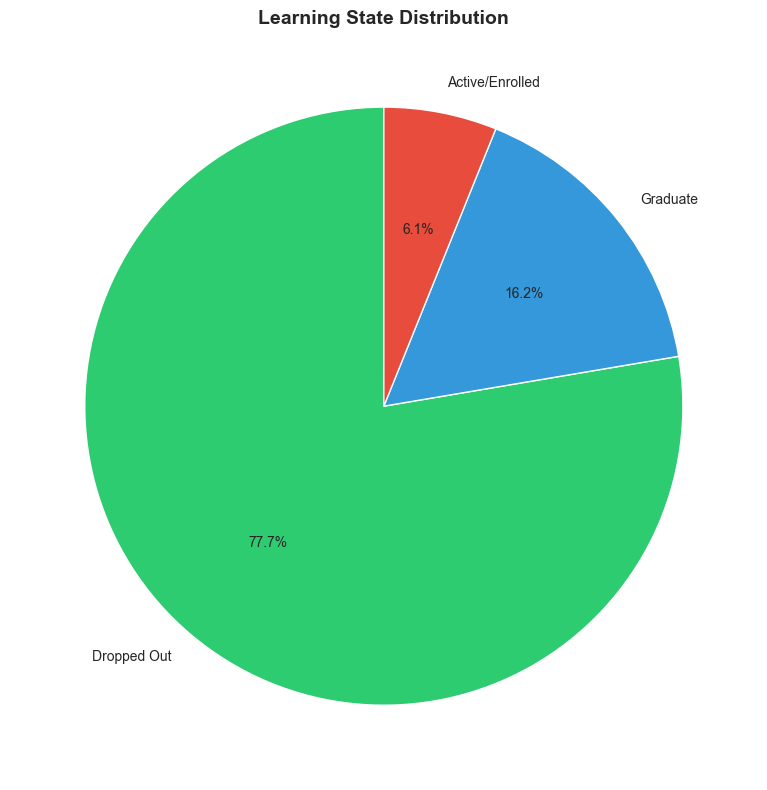

In [20]:
# Q13: Overall learning state distribution
# Purpose: High-level learner status overview

q13 = conn.execute("""
SELECT 
    CASE 
        WHEN is_graduate_learner = 1 THEN 'Graduate'
        WHEN is_active_learner = 1 THEN 'Active/Enrolled'
        WHEN is_a_dropped_out = 1 THEN 'Dropped Out'
        ELSE 'Unknown'
    END AS learning_state,
    COUNT(*) AS learner_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM learners
GROUP BY 1
ORDER BY learner_count DESC
""").df()

print("Q13: Overall Learning State Distribution")
print("=" * 50)
print(q13.to_string(index=False))

# Pie chart
if len(q13) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
    ax.pie(q13['learner_count'], labels=q13['learning_state'], autopct='%1.1f%%', 
           colors=colors[:len(q13)], startangle=90)
    ax.set_title('Learning State Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [21]:
# Q14: Learning state distribution by country
# Purpose: Geographic success patterns

q14 = conn.execute("""
SELECT 
    country_of_residence AS country,
    COUNT(*) AS total,
    SUM(is_graduate_learner) AS graduates,
    SUM(is_active_learner) AS active,
    SUM(is_a_dropped_out) AS dropped_out,
    ROUND(SUM(is_graduate_learner) * 100.0 / COUNT(*), 2) AS graduation_rate_pct,
    ROUND(SUM(is_a_dropped_out) * 100.0 / COUNT(*), 2) AS dropout_rate_pct
FROM learners
WHERE country_of_residence IS NOT NULL
  AND country_of_residence NOT IN ('n/a', '')
GROUP BY country_of_residence
HAVING COUNT(*) >= 1000
ORDER BY graduation_rate_pct DESC
""").df()

print("Q14: Learning State by Country (1000+ enrollments)")
print("=" * 80)
print(q14.to_string(index=False))

Q14: Learning State by Country (1000+ enrollments)
                                             country  total  graduates  active  dropped_out  graduation_rate_pct  dropout_rate_pct
                                            Portugal   1008      537.0    13.0        458.0                53.27             45.44
United Kingdom of Great Britain and Northern Ireland   2627      773.0     5.0       1849.0                29.43             70.38
                                               Ghana 142880    31039.0 13444.0      98397.0                21.72             68.87
                                               Kenya 185443    38022.0 18358.0     129063.0                20.50             69.60
                                             Nigeria 552542   108467.0 23950.0     420125.0                19.63             76.03
                                United Arab Emirates   2353      429.0   121.0       1803.0                18.23             76.63
                                

In [22]:
# Q15: Learning outcomes by gender
# Purpose: Gender equity analysis

q15 = conn.execute("""
SELECT 
    COALESCE(gender, 'Unknown') AS gender,
    COUNT(*) AS total,
    SUM(is_graduate_learner) AS graduates,
    SUM(is_a_dropped_out) AS dropped_out,
    ROUND(SUM(is_graduate_learner) * 100.0 / COUNT(*), 2) AS graduation_rate_pct,
    ROUND(SUM(is_a_dropped_out) * 100.0 / COUNT(*), 2) AS dropout_rate_pct
FROM learners
GROUP BY COALESCE(gender, 'Unknown')
ORDER BY total DESC
""").df()

print("Q15: Learning Outcomes by Gender")
print("=" * 70)
print(q15.to_string(index=False))

Q15: Learning Outcomes by Gender
                 gender  total  graduates  dropped_out  graduation_rate_pct  dropout_rate_pct
                   male 659183   106993.0     498892.0                16.23             75.68
                 female 596808   147940.0     405420.0                24.79             67.93
other/prefer not to say 274576      810.0     273766.0                 0.30             99.70
                    n/a  65284     3203.0      61567.0                 4.91             94.31
                  other    911       98.0        549.0                10.76             60.26
             non binary    436      109.0        300.0                25.00             68.81


In [23]:
# Q16: Learning outcomes by prior education level
# Purpose: Identify success predictors

q16 = conn.execute("""
SELECT 
    education_level_of_study AS education_level,
    COUNT(*) AS total,
    SUM(is_graduate_learner) AS graduates,
    ROUND(SUM(is_graduate_learner) * 100.0 / COUNT(*), 2) AS graduation_rate_pct,
    ROUND(SUM(is_a_dropped_out) * 100.0 / COUNT(*), 2) AS dropout_rate_pct
FROM learners
WHERE education_level_of_study IS NOT NULL
  AND education_level_of_study NOT IN ('n/a', '')
GROUP BY education_level_of_study
HAVING COUNT(*) >= 100
ORDER BY graduation_rate_pct DESC
""").df()

print("Q16: Learning Outcomes by Prior Education Level")
print("=" * 80)
print(q16.to_string(index=False))

Q16: Learning Outcomes by Prior Education Level
                                                                                               education_level  total  graduates  graduation_rate_pct  dropout_rate_pct
                                                                                           9 | Master'S Degree    140       46.0                32.86             67.14
                                                                  5 | Currently Enrolled At University/College    302       99.0                32.78             67.22
                                                                                         8 | Bachelor'S Degree    960      293.0                30.52             69.27
                                                                                        Master'S Degree Or Phd    995      302.0                30.35             69.65
                                                                               Bachelor's degree or equivalent 4

Q17: Monthly Enrollment Trends (since 2020)
start_month  new_enrollments  graduated  dropped_out
 2023-06-01            30993      450.0      30543.0
 2023-07-01            22713      514.0      22199.0
 2023-08-01            20493      789.0      19704.0
 2023-09-01             7148      441.0       6707.0
 2023-10-01             2747      340.0       2407.0
 2023-11-01            12727     1215.0      11512.0
 2024-01-01             4940     4739.0        201.0
 2024-02-01            22424     4732.0      17692.0
 2024-03-01           107508    13999.0      93509.0
 2024-05-01           144645    22979.0     121666.0
 2024-06-01           119586    15170.0     104416.0
 2024-07-01            80103    30348.0      49755.0
 2024-08-01            86841    30771.0      56070.0
 2024-09-01           111213    40967.0      70246.0
 2024-10-01            31763     4820.0      26943.0
 2024-11-01               74        0.0         74.0
 2025-01-01            43574    11116.0      32458.0
 2

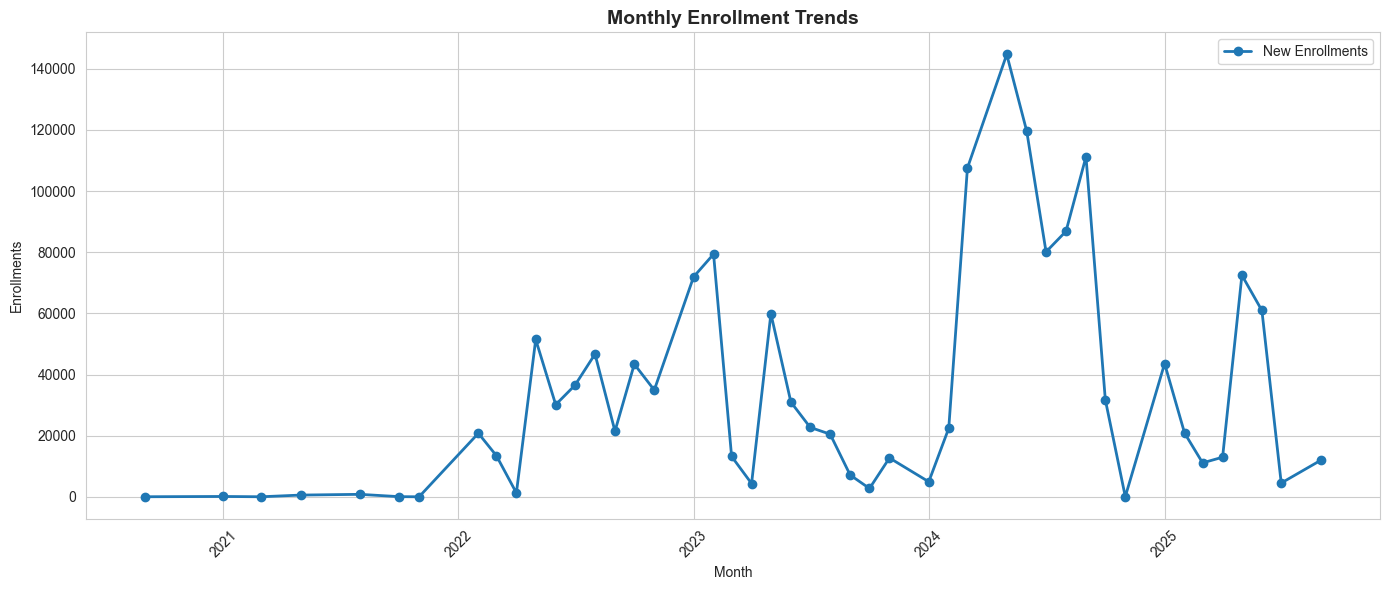

In [24]:
# Q17: Monthly enrollment trends over time
# Purpose: Temporal patterns in enrollment

q17 = conn.execute("""
SELECT 
    DATE_TRUNC('month', TRY_CAST(json_extract_string(learning_details, '$[0].program_start_date') AS DATE)) AS start_month,
    COUNT(*) AS new_enrollments,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduated,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out
FROM learners
WHERE json_extract_string(learning_details, '$[0].program_start_date') NOT IN ('1970-01-01', '', 'n/a')
  AND TRY_CAST(json_extract_string(learning_details, '$[0].program_start_date') AS DATE) >= '2020-01-01'
GROUP BY DATE_TRUNC('month', TRY_CAST(json_extract_string(learning_details, '$[0].program_start_date') AS DATE))
ORDER BY start_month
""").df()

print("Q17: Monthly Enrollment Trends (since 2020)")
print("=" * 60)
print(q17.tail(24).to_string(index=False))  # Show last 2 years

# Time series plot
if len(q17) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(q17['start_month'], q17['new_enrollments'], marker='o', linewidth=2, label='New Enrollments')
    ax.set_title('Monthly Enrollment Trends', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Enrollments')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

---

## Category 4: Employment Outcomes (Q18-Q23)

Analyzing job placement, entrepreneurship, and career outcomes.

In [25]:
# Q18: Employment rates by country (graduates only)
# Purpose: Country-level employment success

q18 = conn.execute("""
SELECT 
    country_of_residence AS country,
    SUM(is_graduate_learner) AS total_graduates,
    SUM(CASE WHEN is_graduate_learner = 1 AND (is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1) THEN 1 ELSE 0 END) AS employed_graduates,
    ROUND(SUM(CASE WHEN is_graduate_learner = 1 AND (is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1) THEN 1 ELSE 0 END) * 100.0 / NULLIF(SUM(is_graduate_learner), 0), 2) AS employment_rate_pct
FROM learners
WHERE country_of_residence IS NOT NULL
  AND country_of_residence NOT IN ('n/a', '')
GROUP BY country_of_residence
HAVING SUM(is_graduate_learner) >= 100
ORDER BY employment_rate_pct DESC
""").df()

print("Q18: Employment Rates by Country (graduates with 100+ grads)")
print("=" * 70)
print(q18.to_string(index=False))

Q18: Employment Rates by Country (graduates with 100+ grads)
                                             country  total_graduates  employed_graduates  employment_rate_pct
                                       Côte d’Ivoire            111.0                54.0                48.65
                                             Senegal            111.0                46.0                41.44
                                            Portugal            537.0               211.0                39.29
                                              Zambia            772.0               262.0                33.94
                                             Tunisia            254.0                86.0                33.86
                                             Namibia            152.0                47.0                30.92
                                              Malawi           1346.0               391.0                29.05
                                               Beni

In [26]:
# Q19: Distribution of employment types
# Purpose: Understand employment patterns

q19 = conn.execute("""
SELECT 
    CASE 
        WHEN is_wage_employed = 1 AND is_running_a_venture = 0 AND is_a_freelancer = 0 THEN 'Wage Employed Only'
        WHEN is_running_a_venture = 1 AND is_wage_employed = 0 AND is_a_freelancer = 0 THEN 'Entrepreneur Only'
        WHEN is_a_freelancer = 1 AND is_wage_employed = 0 AND is_running_a_venture = 0 THEN 'Freelancer Only'
        WHEN is_wage_employed = 1 AND is_running_a_venture = 1 THEN 'Wage + Entrepreneur'
        WHEN is_wage_employed = 1 AND is_a_freelancer = 1 THEN 'Wage + Freelancer'
        WHEN is_wage_employed = 0 AND is_running_a_venture = 0 AND is_a_freelancer = 0 THEN 'Not Employed/Unknown'
        ELSE 'Multiple/Other'
    END AS employment_type,
    COUNT(*) AS learner_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM learners
GROUP BY 1
ORDER BY learner_count DESC
""").df()

print("Q19: Employment Type Distribution")
print("=" * 60)
print(q19.to_string(index=False))

Q19: Employment Type Distribution
     employment_type  learner_count  percentage
Not Employed/Unknown        1534212       96.06
  Wage Employed Only          52949        3.32
   Entrepreneur Only          10037        0.63


In [27]:
# Q20: Salary analysis from placement_details
# Purpose: Compensation insights

q20 = conn.execute("""
SELECT 
    json_extract_string(placement_details, '$[0].salary_range') AS salary_range,
    COUNT(*) AS learner_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM learners
WHERE placement_details IS NOT NULL
  AND placement_details != '[]'
  AND json_extract_string(placement_details, '$[0].salary_range') IS NOT NULL
  AND json_extract_string(placement_details, '$[0].salary_range') NOT IN ('n/a', '')
GROUP BY json_extract_string(placement_details, '$[0].salary_range')
ORDER BY learner_count DESC
""").df()

print("Q20: Salary Range Distribution (from placement_details)")
print("=" * 60)
print(q20.to_string(index=False))

Q20: Salary Range Distribution (from placement_details)
     salary_range  learner_count  percentage
          $0-$500           9054       59.95
       $501-$1000           1914       12.67
          $0-$200           1826       12.09
      $201 - $500            793        5.25
     $1001- $1500            555        3.67
Prefer not to say            264        1.75
     $1501- $2000            244        1.62
      $2001-$3000            183        1.21
      $3001-$4000             99        0.66
      $4001-$6000             56        0.37
           $6000+             54        0.36
           $2001+             16        0.11
          $0-$250             13        0.09
        $250-$500             12        0.08
     $1500- $2000             11        0.07
      $1001-$1500              5        0.03
       $750-$1000              2        0.01
      $1001-$2000              1        0.01
        $500-$750              1        0.01


In [28]:
# Q21: Top job titles from employment_details
# Purpose: Career trajectory insights

q21 = conn.execute("""
SELECT 
    json_extract_string(employment_details, '$[0].job_title') AS job_title,
    COUNT(*) AS occurrence_count,
    COUNT(DISTINCT hashed_email) AS unique_learners
FROM learners
WHERE employment_details IS NOT NULL
  AND employment_details != '[]'
  AND json_extract_string(employment_details, '$[0].job_title') IS NOT NULL
  AND json_extract_string(employment_details, '$[0].job_title') NOT IN ('n/a', '')
GROUP BY json_extract_string(employment_details, '$[0].job_title')
HAVING COUNT(*) >= 10
ORDER BY occurrence_count DESC
LIMIT 30
""").df()

print("Q21: Top 30 Job Titles (from employment_details)")
print("=" * 60)
print(q21.to_string(index=False))

Q21: Top 30 Job Titles (from employment_details)
                      job_title  occurrence_count  unique_learners
                         Intern              6441             6440
       Administrative Assistant              5261             5260
              Virtual Assistant              4656             4656
Customer Service Representative              4582             4582
                        Student              2657             2657
             Internship Trainee              2433             2433
                        Teacher              2368             2368
                 Student Intern              2067             2067
               Graphic Designer              2063             2063
              Software Engineer              1957             1957
           Sales Representative              1753             1753
                   Data Analyst              1596             1596
                     Accountant              1549             1548
             

In [29]:
# Q22: Venture statistics by country (entrepreneurs)
# Purpose: Entrepreneurship impact analysis

q22 = conn.execute("""
SELECT 
    country_of_residence AS country,
    COUNT(DISTINCT hashed_email) AS entrepreneurs,
    SUM(COALESCE(TRY_CAST(json_extract_string(placement_details, '$[0].jobs_created_to_date') AS INT), 0)) AS total_jobs_created,
    SUM(COALESCE(TRY_CAST(json_extract_string(placement_details, '$[0].female_opp_todate') AS INT), 0)) AS female_opportunities
FROM learners
WHERE is_running_a_venture = 1
  AND country_of_residence IS NOT NULL
  AND country_of_residence NOT IN ('n/a', '')
GROUP BY country_of_residence
HAVING COUNT(DISTINCT hashed_email) >= 10
ORDER BY entrepreneurs DESC
LIMIT 20
""").df()

print("Q22: Venture Statistics by Country (10+ entrepreneurs)")
print("=" * 70)
print(q22.to_string(index=False))

Q22: Venture Statistics by Country (10+ entrepreneurs)
     country  entrepreneurs  total_jobs_created  female_opportunities
     Nigeria           4180              5053.0                2584.0
       Kenya           2080              2275.0                1077.0
    Ethiopia            941              1029.0                 495.0
       Ghana            629               698.0                 312.0
South Africa            454               404.0                 198.0
       Egypt            339               206.0                  74.0
      Rwanda            242               234.0                  83.0
     Morocco            209                84.0                  31.0
      Uganda            173               286.0                 154.0
      Malawi             87               206.0                  93.0
      Zambia             71               174.0                  76.0
    Zimbabwe             59               133.0                  46.0
    Tanzania             48        

In [30]:
# Q23: Employment status by program for graduates
# Purpose: Program-to-employment analysis

q23 = conn.execute("""
SELECT 
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS total_graduates,
    SUM(CASE WHEN is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1 THEN 1 ELSE 0 END) AS employed_count,
    ROUND(SUM(CASE WHEN is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS employment_rate_pct,
    SUM(is_wage_employed) AS wage_employed,
    SUM(is_running_a_venture) AS entrepreneurs,
    SUM(is_a_freelancer) AS freelancers
FROM learners
WHERE is_graduate_learner = 1
  AND LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated'
GROUP BY json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 50
ORDER BY employment_rate_pct DESC
""").df()

print("Q23: Employment by Program (graduates only, 50+ grads)")
print("=" * 100)
print(q23.to_string(index=False))

Q23: Employment by Program (graduates only, 50+ grads)
                        program_name  total_graduates  employed_count  employment_rate_pct  wage_employed  entrepreneurs  freelancers
                             Udacity             4058          2074.0                51.11         1922.0          152.0          0.0
                   Financial Analyst            13768          5938.0                43.13         5590.0          348.0          0.0
                Software Engineering             7932          2375.0                29.94         1808.0          567.0          0.0
         Young Entrepreneurs Program              201            54.0                26.87           27.0           27.0          0.0
              AWS Cloud Practitioner               69            18.0                26.09           16.0            2.0          0.0
Introduction to Software Engineering              105            27.0                25.71           27.0            0.0          0.0
       

---

## Category 5: Advanced Cross-Dimensional Analysis (Q24-Q30)

Complex multi-factor analysis combining geography, program, gender, employment, and skills.

In [31]:
# Q24: Female graduates in Egypt who are employed
# Purpose: Cross-dimensional targeting

q24 = conn.execute("""
SELECT 
    city_of_residence AS city,
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS employed_female_graduates,
    CASE 
        WHEN SUM(is_wage_employed) > 0 AND SUM(is_running_a_venture) = 0 THEN 'Wage Employed'
        WHEN SUM(is_running_a_venture) > 0 AND SUM(is_wage_employed) = 0 THEN 'Entrepreneur'
        WHEN SUM(is_a_freelancer) > 0 THEN 'Freelancer'
        ELSE 'Mixed'
    END AS primary_employment_type
FROM learners
WHERE gender = 'female'
  AND is_graduate_learner = 1
  AND LOWER(country_of_residence) LIKE '%egypt%'
  AND (is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1)
GROUP BY city_of_residence, json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 3
ORDER BY employed_female_graduates DESC
LIMIT 20
""").df()

print("Q24: Female Graduates in Egypt Who Are Employed (by city & program)")
print("=" * 80)
print(q24.to_string(index=False))

# Summary stats
q24_summary = conn.execute("""
SELECT 
    COUNT(*) AS total_employed_female_graduates_egypt
FROM learners
WHERE gender = 'female'
  AND is_graduate_learner = 1
  AND LOWER(country_of_residence) LIKE '%egypt%'
  AND (is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1)
""").df()
print(f"\nTotal: {q24_summary['total_employed_female_graduates_egypt'].values[0]:,} employed female graduates in Egypt")

Q24: Female Graduates in Egypt Who Are Employed (by city & program)
           city                    program_name  employed_female_graduates primary_employment_type
          cairo ALX AiCE - AI Career Essentials                        484                   Mixed
          Cairo ALX AiCE - AI Career Essentials                        234                   Mixed
          Cairo                 ALX Foundations                        146                   Mixed
           giza ALX AiCE - AI Career Essentials                        119                   Mixed
     alexandria ALX AiCE - AI Career Essentials                        110                   Mixed
          cairo                 ALX Foundations                        101                   Mixed
          cairo               Virtual Assistant                         57                   Mixed
     alexandria               Virtual Assistant                         28                   Mixed
          cairo               Financial A

In [32]:
# Q25: Data Analysis graduates in Morocco who started ventures
# Purpose: Cross-dimensional entrepreneurship analysis

q25 = conn.execute("""
SELECT 
    city_of_residence AS city,
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS entrepreneurs
FROM learners
WHERE LOWER(country_of_residence) LIKE '%morocco%'
  AND is_graduate_learner = 1
  AND is_running_a_venture = 1
  AND LOWER(learning_details) LIKE '%data%'
GROUP BY city_of_residence, json_extract_string(learning_details, '$[0].program_name')
ORDER BY entrepreneurs DESC
LIMIT 20
""").df()

print("Q25: Data Analysis Graduates in Morocco Who Started Ventures")
print("=" * 80)
if len(q25) > 0:
    print(q25.to_string(index=False))
else:
    print("No matching records found (Data Analysis entrepreneurs in Morocco)")
    # Try broader search
    q25b = conn.execute("""
    SELECT 
        json_extract_string(learning_details, '$[0].program_name') AS program_name,
        COUNT(*) AS entrepreneurs
    FROM learners
    WHERE LOWER(country_of_residence) LIKE '%morocco%'
      AND is_graduate_learner = 1
      AND is_running_a_venture = 1
    GROUP BY json_extract_string(learning_details, '$[0].program_name')
    ORDER BY entrepreneurs DESC
    """).df()
    print("\nAlternative: All Morocco graduate entrepreneurs by program:")
    print(q25b.to_string(index=False))

Q25: Data Analysis Graduates in Morocco Who Started Ventures
No matching records found (Data Analysis entrepreneurs in Morocco)

Alternative: All Morocco graduate entrepreneurs by program:
                   program_name  entrepreneurs
                ALX Foundations             52
ALX AiCE - AI Career Essentials             28
           Software Engineering             21
              Virtual Assistant             18
                Founder Academy             16
                        Udacity              3
       Back-End Web Development              2
              Financial Analyst              2
         AWS Cloud Practitioner              1


In [33]:
# Q26: Skills analysis by employment status
# Purpose: Skills-employment correlation

q26 = conn.execute("""
WITH skill_counts AS (
    SELECT 
        TRIM(unnest(string_split(skills_list, ','))) AS skill_name,
        CASE 
            WHEN is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1 THEN 'Employed'
            ELSE 'Not Employed'
        END AS employment_status
    FROM learners
    WHERE is_graduate_learner = 1
      AND skills_list IS NOT NULL
      AND skills_list != ''
)
SELECT 
    skill_name,
    SUM(CASE WHEN employment_status = 'Employed' THEN 1 ELSE 0 END) AS employed_count,
    SUM(CASE WHEN employment_status = 'Not Employed' THEN 1 ELSE 0 END) AS not_employed_count,
    COUNT(*) AS total_count,
    ROUND(SUM(CASE WHEN employment_status = 'Employed' THEN 1 ELSE 0 END) * 100.0 / NULLIF(COUNT(*), 0), 2) AS employed_pct
FROM skill_counts
GROUP BY skill_name
HAVING COUNT(*) >= 100
ORDER BY employed_pct DESC
LIMIT 25
""").df()

print("Q26: Skills by Employment Status (graduates with 100+ occurrences)")
print("=" * 90)
print(q26.to_string(index=False))

Q26: Skills by Employment Status (graduates with 100+ occurrences)
                            skill_name  employed_count  not_employed_count  total_count  employed_pct
                            Javascript           105.0                23.0          128         82.03
                       Web Development           173.0                62.0          235         73.62
                   Enterprise Software            86.0                34.0          120         71.67
                          Data Science           452.0               187.0          639         70.74
                 Business Intelligence           228.0               101.0          329         69.30
                                   AWS            85.0                39.0          124         68.55
                     Development Tools           100.0                47.0          147         68.03
Software Development Life Cycle (SDLC)           129.0                61.0          190         67.89
               

In [34]:
# Q27: Program success by prior education field
# Purpose: Program-education fit analysis

q27 = conn.execute("""
SELECT 
    education_field_of_study AS prior_education_field,
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS enrollments,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduates,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS graduation_rate_pct
FROM learners
WHERE education_field_of_study IS NOT NULL
  AND education_field_of_study NOT IN ('n/a', '')
GROUP BY education_field_of_study, json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 100
ORDER BY graduation_rate_pct DESC
LIMIT 30
""").df()

print("Q27: Program Success by Prior Education Field")
print("=" * 90)
print(q27.to_string(index=False))

Q27: Program Success by Prior Education Field
                                                                                                                   prior_education_field       program_name  enrollments  graduates  graduation_rate_pct
                                                                                                    Sciences (Biology Chemistry Physics)  Virtual Assistant          581      400.0                68.85
                                                                                                      Medical Pharmacy & Dental Sciences  Virtual Assistant          222      142.0                63.96
                                                                                           Agriculture Forestry Fisheries And Veterinary  Virtual Assistant          333      206.0                61.86
                                                                                              Philosophy Religion Psychology & Sociology  Virtual Assi

In [35]:
# Q28: High performer profile analysis (90+ LMS score)
# Purpose: Identify success predictors

q28 = conn.execute("""
SELECT 
    gender,
    country_of_residence AS country,
    education_level_of_study AS education_level,
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS high_performers,
    ROUND(AVG(TRY_CAST(json_extract_string(learning_details, '$[0].lms_overall_score') AS DOUBLE)), 2) AS avg_score,
    SUM(CASE WHEN is_wage_employed = 1 OR is_running_a_venture = 1 THEN 1 ELSE 0 END) AS employed_count
FROM learners
WHERE json_extract_string(learning_details, '$[0].lms_overall_score') NOT IN ('-99', '', 'n/a')
  AND TRY_CAST(json_extract_string(learning_details, '$[0].lms_overall_score') AS DOUBLE) >= 90
GROUP BY gender, country_of_residence, education_level_of_study, json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 10
ORDER BY high_performers DESC
LIMIT 30
""").df()

print("Q28: High Performer Profiles (LMS Score 90+)")
print("=" * 100)
print(q28.to_string(index=False))

Q28: High Performer Profiles (LMS Score 90+)
gender      country                                                                                            education_level                    program_name  high_performers  avg_score  employed_count
female      Nigeria                                                                            Bachelor's degree or equivalent               Virtual Assistant            30493      96.55          1983.0
  male      Nigeria                                                                            Bachelor's degree or equivalent               Virtual Assistant             6613      96.43           433.0
female        Kenya                                                                            Bachelor's degree or equivalent               Virtual Assistant             6137      97.36           397.0
female      Nigeria                                                                            Bachelor's degree or equivalent ALX AiCE - AI Ca

In [36]:
# Q29: Dropout risk factors analysis
# Purpose: Identify dropout patterns

q29 = conn.execute("""
SELECT 
    gender,
    education_level_of_study AS education_level,
    json_extract_string(learning_details, '$[0].program_name') AS program_name,
    COUNT(*) AS total_enrolled,
    SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) AS dropped_out,
    ROUND(SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) LIKE '%dropped%' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS dropout_rate_pct
FROM learners
WHERE education_level_of_study IS NOT NULL
  AND education_level_of_study NOT IN ('n/a', '')
GROUP BY gender, education_level_of_study, json_extract_string(learning_details, '$[0].program_name')
HAVING COUNT(*) >= 100
ORDER BY dropout_rate_pct DESC
LIMIT 30
""").df()

print("Q29: Dropout Risk Factors (100+ enrollments)")
print("=" * 90)
print(q29.to_string(index=False))

Q29: Dropout Risk Factors (100+ enrollments)
                 gender                                                                                                education_level                    program_name  total_enrolled  dropped_out  dropout_rate_pct
other/prefer not to say         At Least 1 Year Of Vocational Or Polytechnic Or College Education Completed But Not Currently Enrolled            Software Engineering             365        365.0            100.00
other/prefer not to say                                                                                                              8            Software Engineering             202        202.0            100.00
other/prefer not to say                                                                              Currently Enrolled In High School            Software Engineering            9417       9411.0             99.94
other/prefer not to say                                                                            

Q30: Complete Learner Funnel by Program
                        program_name  total_enrolled  started_assignments  started_pct  graduated  graduation_pct  employed  employment_rate_of_graduates_pct
                Software Engineering          467697                  0.0         0.00     7932.0            1.70    8276.0                            104.34
     ALX AiCE - AI Career Essentials          449135             127643.0        28.42    73839.0           16.44   13026.0                             17.64
                   Virtual Assistant          323220             149663.0        46.30   115413.0           35.71   20836.0                             18.05
                     ALX Foundations          194584              52255.0        26.85    33829.0           17.39    7046.0                             20.83
                   Financial Analyst           46133                  0.0         0.00    13768.0           29.84    7809.0                             56.72
            

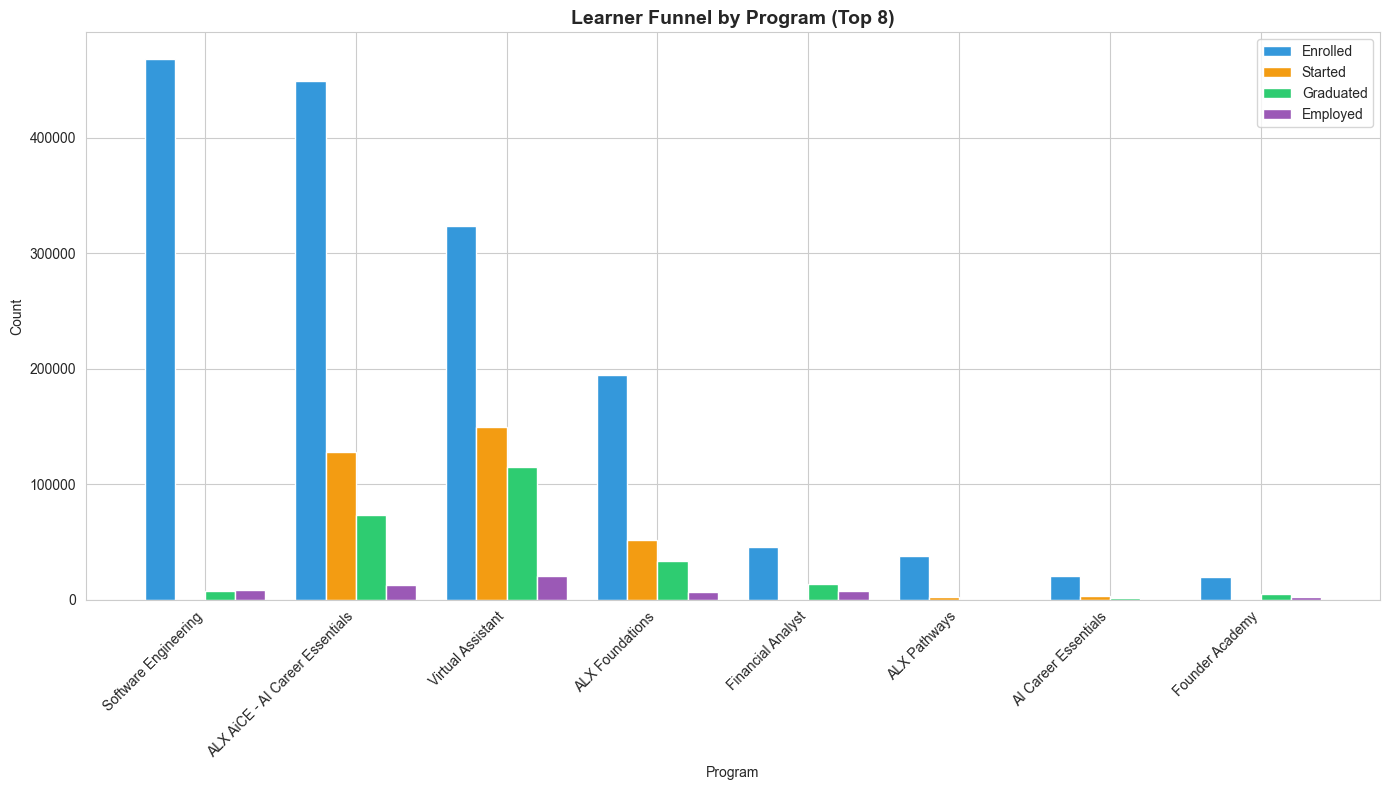

In [37]:
# Q30: Complete learner funnel analysis by program
# Purpose: End-to-end conversion funnel

q30 = conn.execute("""
WITH funnel AS (
    SELECT 
        json_extract_string(learning_details, '$[0].program_name') AS program_name,
        COUNT(*) AS total_enrolled,
        SUM(CASE WHEN json_extract_string(learning_details, '$[0].no_of_submissions') NOT IN ('-99', '0', '', 'n/a') 
                  AND TRY_CAST(json_extract_string(learning_details, '$[0].no_of_submissions') AS INT) > 0 THEN 1 ELSE 0 END) AS started_assignments,
        SUM(CASE WHEN LOWER(json_extract_string(learning_details, '$[0].enrollment_status')) = 'graduated' THEN 1 ELSE 0 END) AS graduated,
        SUM(CASE WHEN is_wage_employed = 1 OR is_running_a_venture = 1 OR is_a_freelancer = 1 THEN 1 ELSE 0 END) AS employed
    FROM learners
    GROUP BY json_extract_string(learning_details, '$[0].program_name')
    HAVING COUNT(*) >= 100
)
SELECT 
    program_name,
    total_enrolled,
    started_assignments,
    ROUND(started_assignments * 100.0 / total_enrolled, 2) AS started_pct,
    graduated,
    ROUND(graduated * 100.0 / total_enrolled, 2) AS graduation_pct,
    employed,
    ROUND(employed * 100.0 / NULLIF(graduated, 0), 2) AS employment_rate_of_graduates_pct
FROM funnel
ORDER BY total_enrolled DESC
""").df()

print("Q30: Complete Learner Funnel by Program")
print("=" * 120)
print(q30.to_string(index=False))

# Funnel visualization
if len(q30) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    top_programs = q30.head(8)
    x = range(len(top_programs))
    width = 0.2
    
    ax.bar([i - width*1.5 for i in x], top_programs['total_enrolled'], width, label='Enrolled', color='#3498db')
    ax.bar([i - width*0.5 for i in x], top_programs['started_assignments'], width, label='Started', color='#f39c12')
    ax.bar([i + width*0.5 for i in x], top_programs['graduated'], width, label='Graduated', color='#2ecc71')
    ax.bar([i + width*1.5 for i in x], top_programs['employed'], width, label='Employed', color='#9b59b6')
    
    ax.set_xlabel('Program')
    ax.set_ylabel('Count')
    ax.set_title('Learner Funnel by Program (Top 8)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_programs['program_name'], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

---

## Summary & Key Insights

### Quick Reference: Query Results

| Category | Key Findings |
|----------|-------------|
| Geographic | Top countries, Egypt vs Morocco comparison |
| Programs | 26 programs, graduation rates vary significantly |
| Learning State | 16% graduate, 6% active, 78% dropped out |
| Employment | 18% wage employed, 4% entrepreneurs |
| Cross-Dimensional | Skills-employment correlation, risk factors |

### Data Coverage Notes
- `learning_details`: 100% coverage (all learners)
- `employment_details`: ~18% coverage (self-reported)
- `placement_details`: ~4% coverage (program placements only)

### Sentinel Values Handled
- `-99` → NULL (missing numeric)
- `1970-01-01` → NULL (invalid date)
- `'[]'` → Empty array (no data)

In [38]:
# Close DuckDB connection when done
conn.close()
print("DuckDB connection closed.")

DuckDB connection closed.
